# • R's Fable/HTS Replication1

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/AustralianDomesticTourism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In many cases, only the time series at the lowest level of the hierarchies (bottom time series) are available. `HierarchicalForecast` has tools to create time series for all hierarchies. In this notebook we will see how to do it.

In [1]:

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
import pandas as pd

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from datasetsforecast.hierarchical import HierarchicalData
import numpy as np
from statsforecast.models import ETS


/home/arindam/anaconda3/envs/kdd23/lib/python3.9/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Aggregate bottom time series

In this example we will use the [Tourism](https://otexts.com/fpp3/tourism.html) dataset from the [Forecasting: Principles and Practice](https://otexts.com/fpp3/) book. The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [2]:
# Load TourismSmall dataset
Y_df, S, tags = HierarchicalData.load('./data', 'TourismSmall')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [3]:
Y_df

,unique_id,ds,y
0,total,1998-03-31,84503
1,total,1998-06-30,65312
2,total,1998-09-30,72753
3,total,1998-12-31,70880
4,total,1999-03-31,86893
...,...,...,...
3199,nt-oth-noncity,2005-12-31,59
3200,nt-oth-noncity,2006-03-31,25
3201,nt-oth-noncity,2006-06-30,52
3202,nt-oth-noncity,2006-09-30,72


In [4]:
S

,nsw-hol-city,nsw-hol-noncity,vic-hol-city,vic-hol-noncity,qld-hol-city,qld-hol-noncity,sa-hol-city,sa-hol-noncity,wa-hol-city,wa-hol-noncity,...,qld-oth-city,qld-oth-noncity,sa-oth-city,sa-oth-noncity,wa-oth-city,wa-oth-noncity,tas-oth-city,tas-oth-noncity,nt-oth-city,nt-oth-noncity
total,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
hol,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vfr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wa-oth-noncity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
tas-oth-city,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
tas-oth-noncity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
nt-oth-city,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
tags

{'Country': array(['total'], dtype=object),
 'Country/Purpose': array(['hol', 'vfr', 'bus', 'oth'], dtype=object),
 'Country/Purpose/State': array(['nsw-hol', 'vic-hol', 'qld-hol', 'sa-hol', 'wa-hol', 'tas-hol',
        'nt-hol', 'nsw-vfr', 'vic-vfr', 'qld-vfr', 'sa-vfr', 'wa-vfr',
        'tas-vfr', 'nt-vfr', 'nsw-bus', 'vic-bus', 'qld-bus', 'sa-bus',
        'wa-bus', 'tas-bus', 'nt-bus', 'nsw-oth', 'vic-oth', 'qld-oth',
        'sa-oth', 'wa-oth', 'tas-oth', 'nt-oth'], dtype=object),
 'Country/Purpose/State/CityNonCity': array(['nsw-hol-city', 'nsw-hol-noncity', 'vic-hol-city',
        'vic-hol-noncity', 'qld-hol-city', 'qld-hol-noncity',
        'sa-hol-city', 'sa-hol-noncity', 'wa-hol-city', 'wa-hol-noncity',
        'tas-hol-city', 'tas-hol-noncity', 'nt-hol-city', 'nt-hol-noncity',
        'nsw-vfr-city', 'nsw-vfr-noncity', 'vic-vfr-city',
        'vic-vfr-noncity', 'qld-vfr-city', 'qld-vfr-noncity',
        'sa-vfr-city', 'sa-vfr-noncity', 'wa-vfr-city', 'wa-vfr-noncity',
     

### Split Train/Test sets

We use the final horizon as test set.

In [6]:
HORIZON = 8
FREQUENCY = "1Q"

In [7]:
Y_test_df = Y_df.groupby('unique_id').tail(HORIZON)
Y_train_df = Y_df.drop(Y_test_df.index)

In [8]:
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [9]:
Y_train_df.groupby('unique_id').size()

unique_id
bus                28
hol                28
nsw-bus            28
nsw-bus-city       28
nsw-bus-noncity    28
                   ..
wa-oth-city        28
wa-oth-noncity     28
wa-vfr             28
wa-vfr-city        28
wa-vfr-noncity     28
Length: 89, dtype: int64

## Computing base forecasts

The following cell computes the **base forecasts** for each time series in `Y_df` using the `auto_arima` and `naive` models. Observe that `Y_hat_df` contains the forecasts but they are not coherent.

In [10]:
# Convert train df to gluonts format
# from data_utils import convert_df_to_gluonts_iter

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

def convert_df_to_gluonts_iter(df: pd.DataFrame, horizon: int, frequency: str):

    unq_ids = np.unique(df.index)

    all_ts = []
    for id_ in unq_ids:
        df_one_ts = df[df.index == id_].sort_values("ds")
        start_time = df_one_ts["ds"][0]
        target_vals = df_one_ts["y"].values
        # print(id_, start_time, target_vals)
        all_ts.append(
            {
                FieldName.TARGET: target_vals,
                FieldName.START: start_time,
                FieldName.ITEM_ID: id_
            }
        )
    return ListDataset(all_ts, freq=frequency)

gluon_dset_train = convert_df_to_gluonts_iter(Y_train_df, HORIZON, FREQUENCY)
gluon_dset_test = convert_df_to_gluonts_iter(Y_df.set_index('unique_id'), HORIZON, FREQUENCY)

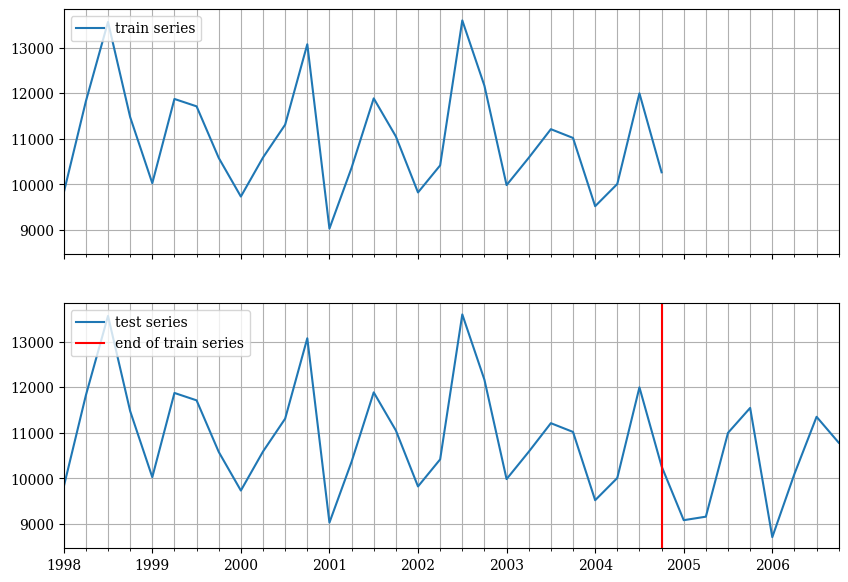

In [11]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas

train_entry = next(iter(gluon_dset_train))
test_entry = next(iter(gluon_dset_test))

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()



In [12]:

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.model.n_beats import NBEATSEnsembleEstimator
from gluonts.mx.trainer import Trainer

EPOCHS = 10
FREQ = FREQUENCY
LR = 1e-3
BATCHES_PER_EPOCH = 100

# Get best model params from HPO
CONTEXT_LEN = 2*HORIZON
# num_layers = 2
# dropout_rate = 0.4
# EPOCHS = 25
# num_cells = 40

estimator = NBEATSEnsembleEstimator(
    freq=FREQ,
    prediction_length=HORIZON,
    trainer=Trainer(ctx="cpu", epochs=EPOCHS, learning_rate=1e-3, num_batches_per_epoch=BATCHES_PER_EPOCH),
    meta_context_length=[HORIZON, CONTEXT_LEN],
    meta_loss_function=["sMAPE"],
    meta_bagging_size=5,
)

predictor = estimator.train(gluon_dset_train)

# # Fit and predict with N-BEATS and N-HiTS models
# models = [NBEATS(input_size=CONTEXT_LEN, h=HORIZON, max_epochs=EPOCHS)]
# fcst = NeuralForecast(models=models, freq='M')
# fcst.fit(df=Y_train_df)

INFO:gluonts.mx.context:Using CPU
/home/arindam/anaconda3/envs/kdd23/lib/python3.9/site-packages/gluonts/model/n_beats/__init__.py:22: FutureWarning: The module gluonts.model.n_beats has been moved to gluonts.mx.model.n_beats. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import NBEATSEstimator, NBEATSEnsembleEstimator, NBEATSEnsemblePredictor'.
  warnings.warn(
INFO:root:Training estimator 1/10.
INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001


TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=10, hybridize=True, init="xavier", learning_rate=0.001, num_batches_per_epoch=100, weight_decay=1e-08)


100%|██████████| 100/100 [00:10<00:00,  9.28it/s, epoch=1/10, avg_epoch_loss=5.34]
INFO:gluonts.trainer:Epoch[0] Elapsed time 10.781 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=5.342127
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.32it/s, epoch=2/10, avg_epoch_loss=3.89]
INFO:gluonts.trainer:Epoch[1] Elapsed time 9.699 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=3.892704
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.60it/s, epoch=3/10, avg_epoch_loss=3.81]
INFO:gluonts.trainer:Epoch[2] Elapsed time 10.421 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=3.809101
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.86it/s, epoch=4/10, avg_epoch_loss=3.69]
INFO:gluonts.trainer:Epoch[3] Elapsed time 10.148 seconds
INFO:gluonts.trainer:Epoch[3] Evaluation metric 'epoch_loss'=3.69439

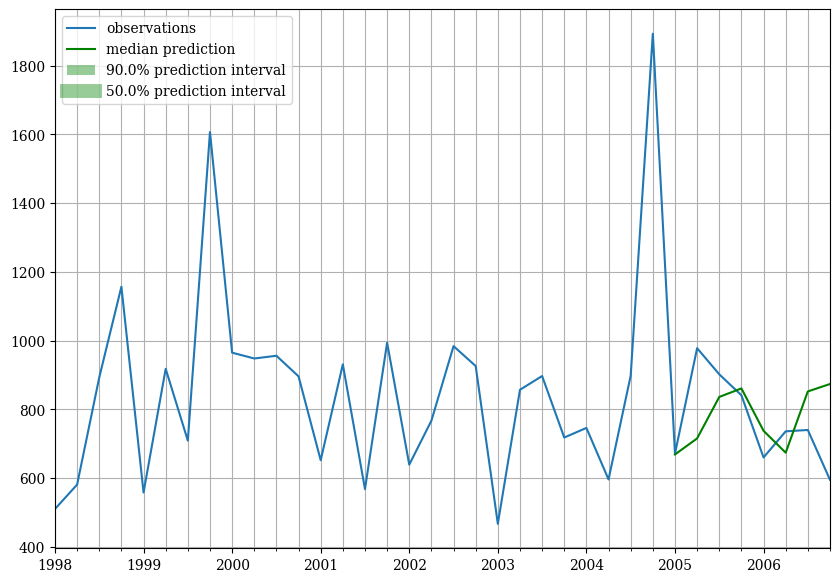

In [13]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=gluon_dset_test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[10]
forecast_entry = forecasts[10]
plot_prob_forecasts(ts_entry, forecast_entry)

### Convert the forecasts iterator into pandas df

In [14]:
def convert_gluonts_iter_to_df(
    gluon_iter,
    test_dates
):
    out = []
    dates = []
    ids = []
    for x in gluon_iter:
        ids.extend([x.item_id]*HORIZON)
        # out.extend(np.mean(x.samples, axis=0).reshape(-1))
        out.extend(x.samples.flatten())
        dates.extend(test_dates)
    out = pd.DataFrame({"unique_id": ids, "ds": dates, "y_hat": out})
    out = out.set_index("unique_id")
    return out

test_dates = Y_test_df["ds"].unique()
test_dates.sort()
forecast_df = convert_gluonts_iter_to_df(forecasts, test_dates)
print(forecast_df)

                       ds         y_hat
unique_id                              
bus            2005-03-31   9764.089844
bus            2005-06-30  10421.828125
bus            2005-09-30  12043.427734
bus            2005-12-31  10898.847656
bus            2006-03-31   9642.189453
...                   ...           ...
wa-vfr-noncity 2005-12-31    910.604187
wa-vfr-noncity 2006-03-31    927.192932
wa-vfr-noncity 2006-06-30    833.494019
wa-vfr-noncity 2006-09-30    964.522949
wa-vfr-noncity 2006-12-31    950.812134

[712 rows x 2 columns]


### Computing in-sample forecasts needed for MinT, ERM methods
Note that the model is already trained on the training part of the data. Now, the in-sample forecasts are obtained by a moving window method. These in-sample forecasts are needed to estimate the residual covariance matrix in MinT and ERM methods.

In [15]:
dates = Y_df.ds.unique()
dates.sort()
dates_train = Y_train_df.ds.unique()
dates_train.sort()
Y_hat_in_sample = None
for i in range(0, len(dates_train)-HORIZON-CONTEXT_LEN+1):
    # print(i, i+CONTEXT_LEN, i+CONTEXT_LEN+HORIZON)
    backtest_history = Y_train_df[(Y_train_df.ds >= dates[i]) & (Y_train_df.ds < dates[i+CONTEXT_LEN])]
    end_pt = i+CONTEXT_LEN+HORIZON
    if end_pt < len(dates_train):
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN]) & (Y_train_df.ds < dates[end_pt])]
    else:
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN])]
    # print(len(backtest_test_true))
    backtest_history_iter = convert_df_to_gluonts_iter(backtest_history, HORIZON, FREQUENCY)
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=backtest_history_iter,  # test dataset
                            predictor=predictor,  # predictor
                            # num_samples=100,  # number of sample paths we want for evaluation
                        )
    forecasts = list(forecast_it)
    # Y_hat_in_sample_part = fcst.predict(df=backtest_history)
    test_dates = backtest_test_true["ds"].unique()
    test_dates.sort()
    Y_hat_in_sample_part = convert_gluonts_iter_to_df(forecasts, test_dates)
    # Y_hat_in_sample_part["ds"] = backtest_test_true["ds"].values
    first_horizon_date = backtest_test_true["ds"].unique()[0]
    if Y_hat_in_sample is None:
        Y_hat_in_sample = Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]
    else:
        if i == len(dates_train)-HORIZON-CONTEXT_LEN:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part])
        else:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]])

In [16]:
Y_hat_in_sample_part

,ds,y_hat
unique_id,,
bus,2003-03-31,10316.986328
bus,2003-06-30,10551.564453
bus,2003-09-30,11321.964844
bus,2003-12-31,11613.432617
bus,2004-03-31,10315.692383
...,...,...
wa-vfr-noncity,2003-12-31,739.245239
wa-vfr-noncity,2004-03-31,711.232910
wa-vfr-noncity,2004-06-30,724.385376


## Predict on test

In [17]:
Y_hat_df = forecast_df
Y_hat_df

,ds,y_hat
unique_id,,
bus,2005-03-31,9764.089844
bus,2005-06-30,10421.828125
bus,2005-09-30,12043.427734
bus,2005-12-31,10898.847656
bus,2006-03-31,9642.189453
...,...,...
wa-vfr-noncity,2005-12-31,910.604187
wa-vfr-noncity,2006-03-31,927.192932
wa-vfr-noncity,2006-06-30,833.494019


In [18]:
# Create Y_df with y_hat_in_sample
Y_train_df_extended = Y_train_df.merge(Y_hat_in_sample, on=["ds", "unique_id"], how="inner")
Y_train_df_extended

,ds,y,y_hat
unique_id,,,
total,2002-03-31,83938,81752.960938
total,2002-06-30,63529,69632.031250
total,2002-09-30,75540,70089.796875
total,2002-12-31,75663,70072.437500
total,2003-03-31,83860,81759.781250
...,...,...,...
nt-oth-noncity,2003-12-31,132,154.033173
nt-oth-noncity,2004-03-31,12,50.912121
nt-oth-noncity,2004-06-30,40,74.669952


## Reconcile forecasts

The following cell makes the previous forecasts coherent using the `HierarchicalReconciliation` class. Since the hierarchy structure is not strict, we can't use methods such as `TopDown` or `MiddleOut`. In this example we use `BottomUp` and `MinTrace`.

In [19]:
from hierarchicalforecast.methods import BottomUp, MinTrace, ERM

reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols'),
    ERM(method='reg')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df_extended, S=S, tags=tags)

The dataframe `Y_rec_df` contains the reconciled forecasts.

In [20]:
Y_rec_df

,ds,y_hat,y_hat/BottomUp,y_hat/MinTrace_method-mint_shrink,y_hat/MinTrace_method-ols,y_hat/ERM_method-reg_lambda_reg-0.01
unique_id,,,,,,
total,2005-03-31,83056.625000,80382.859375,81243.137081,82741.578282,83642.507812
total,2005-06-30,68249.078125,67623.656250,67650.481748,68117.745617,68647.312500
total,2005-09-30,73443.296875,70502.718750,71543.400335,73247.447324,73808.859375
total,2005-12-31,73684.328125,69856.187500,71189.777422,73341.777589,76248.304688
total,2006-03-31,81944.046875,79681.289062,80713.763836,81819.257684,79400.351562
...,...,...,...,...,...,...
nt-oth-noncity,2005-12-31,142.664810,142.664810,145.347785,191.233144,50.438663
nt-oth-noncity,2006-03-31,2.453678,2.453678,0.791938,16.185490,40.958740
nt-oth-noncity,2006-06-30,74.484612,74.484612,73.995922,106.779665,129.575592


## Evaluation 

The `HierarchicalForecast` package includes the `HierarchicalEvaluation` class to evaluate the different hierarchies and also is capable of compute scaled metrics compared to a benchmark model.

In [21]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

def mase(y, y_hat, y_insample, seasonality=4):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return np.mean(errors / scale)

def rmsse(y, y_hat, y_insample):
    errors = np.mean(np.square(y - y_hat), axis=1)
    scale = np.mean(np.square(y_insample[:, 1:] - y_insample[:, :-1]), axis=1)
    return np.mean(np.sqrt(errors / scale))

eval_tags = {}
eval_tags['Total'] = tags['Country']
eval_tags['Purpose'] = tags['Country/Purpose']
# eval_tags['State'] = tags['Country/State']#np.concatenate([val for key, val in tags.items() if 'State' in key])
# eval_tags['Regions'] = tags['Country/State/Region']
eval_tags['Purpose-State'] = tags['Country/Purpose/State']
# eval_tags['Bottom'] = tags['Country/State/Region/Purpose']
eval_tags['Regions'] = tags['Country/Purpose/State/CityNonCity']
# eval_tags['All'] = np.concatenate(list(tags.values()))

evaluator = HierarchicalEvaluation(evaluators=[rmse, mase, rmsse])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df
)
evaluation = evaluation.drop('Overall')
# evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation.columns = ['Base', 'BottomUp', 'MinTrace(ols)', 'MinTrace(mint_shrink)', 'ERM']
evaluation = evaluation.applymap('{:.4f}'.format)

/tmp/ipykernel_1379152/3203693170.py:31: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  evaluation = evaluation.drop('Overall')


### RMSE

The following table shows the performance measured using RMSE across levels for each reconciliation method.

In [22]:
score_df = evaluation.query('metric == "rmse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Total,rmse,6673.5873,4959.1011,5387.3721,6468.6329,7845.7837
Purpose,rmse,1903.5059,1698.7726,1769.3659,1995.5694,2812.9949
Purpose-State,rmse,377.2308,375.7335,383.2036,403.0433,641.5588
Regions,rmse,227.9497,227.9497,231.8145,239.7900,388.9482


### MASE


The following table shows the performance measured using MASE across levels for each reconciliation method.

In [23]:
evaluation.query('metric == "mase"')

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Total,mase,2.1406,1.6495,1.7514,2.0776,2.5947
Purpose,mase,1.3767,1.1883,1.2446,1.4616,1.9756
Purpose-State,mase,0.8781,0.8798,0.8891,0.9959,1.5528
Regions,mase,0.8125,0.8125,0.8244,0.8960,1.4233


### RMSSE

In [24]:
score_df = evaluation.query('metric == "rmsse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Total,rmsse,0.5601,0.4162,0.4522,0.5429,0.6585
Purpose,rmsse,0.5356,0.4502,0.4829,0.5794,0.7500
Purpose-State,rmsse,0.5393,0.5314,0.5427,0.6225,0.9885
Regions,rmsse,0.5639,0.5639,0.5718,0.6181,0.9910


In [25]:
score_df.astype(float).mean()

Base                     0.549725
BottomUp                 0.490425
MinTrace(ols)            0.512400
MinTrace(mint_shrink)    0.590725
ERM                      0.847000
dtype: float64

### Comparison fable

Observe that we can recover the results reported by the [Forecasting: Principles and Practice](https://otexts.com/fpp3/tourism.html). The original results were calculated using the R package [fable](https://github.com/tidyverts/fable).

![Fable's reconciliation results](./imgs/AustralianDomesticTourism-results-fable.png)

### References
- [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition: 
Chapter 11: Forecasting hierarchical and grouped series.". OTexts: Melbourne, Australia. OTexts.com/fpp3 
Accessed on July 2022.](https://otexts.com/fpp3/hierarchical.html)
- [Rob Hyndman, Alan Lee, Earo Wang, Shanika Wickramasuriya, and Maintainer Earo Wang (2021). "hts: Hierarchical and Grouped Time Series". URL https://CRAN.R-project.org/package=hts. R package version 0.3.1.](https://cran.r-project.org/web/packages/hts/index.html)
- [Mitchell O’Hara-Wild, Rob Hyndman, Earo Wang, Gabriel Caceres, Tim-Gunnar Hensel, and Timothy Hyndman (2021). "fable: Forecasting Models for Tidy Time Series". URL https://CRAN.R-project.org/package=fable. R package version 6.0.2.](https://CRAN.R-project.org/package=fable)